Есть металлургический комбинат ООО «Так закаляем сталь», который решил оптимизировать расходы на одном из технологических процессов его производства.
________

**Описание данных:** Данные состоят из файлов, полученных из разных источников:

* **data_arc_new.csv** — данные об электродах;
* **data_bulk_new.csv** — данные о подаче сыпучих материалов (объём);
* **data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время);
* **data_gas_new.csv** — данные о продувке сплава газом;
* **data_temp_new.csv** — результаты измерения температуры;
* **data_wire_new.csv** — данные о проволочных материалах (объём);
* **data_wire_time_new.csv** — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.
________

**Задача:** Построить модель, которая предскажет температуру стали.
________

**Цель:** С помощью построенной модели машинного обучения компания должна уменьшить потребление электроэнергии на этапе обработки стали.
________

## Предобработка данных

In [1]:
#Подгружаем необходимые библиотеки для работы с данными и машинного обучения
import warnings
import timeit

import pandas as pd

import catboost
import phik
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import (LinearRegression, 
                                  Ridge, 
                                  Lasso,
                                  ElasticNet)
from catboost import CatBoostRegressor
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             f1_score, 
                             roc_curve, 
                             roc_auc_score, 
                             confusion_matrix,
                             accuracy_score,
                             make_scorer)
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.dummy import DummyRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats as st
from statsmodels.tsa.seasonal import seasonal_decompose

#Подгружаем дополнительные полезные библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#Уберем warnings, чтобы не мешали
warnings.filterwarnings("ignore")

Предобработку данных проводим для каждого файла и датафрейма отдельно

### Данные об электродах

In [3]:
#Подгрузим данные об электродах
try:
    data_arc = pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Ля финаль/data_arc_new.csv')
except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
--------------------------------------------------
                       count      mean      std      min      25%       50%  \
key                  14876.0  1615.220  934.572    1.000  806.000  1617.000   
Активная мощность    14876.0     0.663    0.259    0.223    0.467     0.600   
Реактивная мощность  14876.0     0.439    5.873 -715.480    0.337     0.442   

                          75%       max  
key                  2429.000  3241.000  
Активная мощность  

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


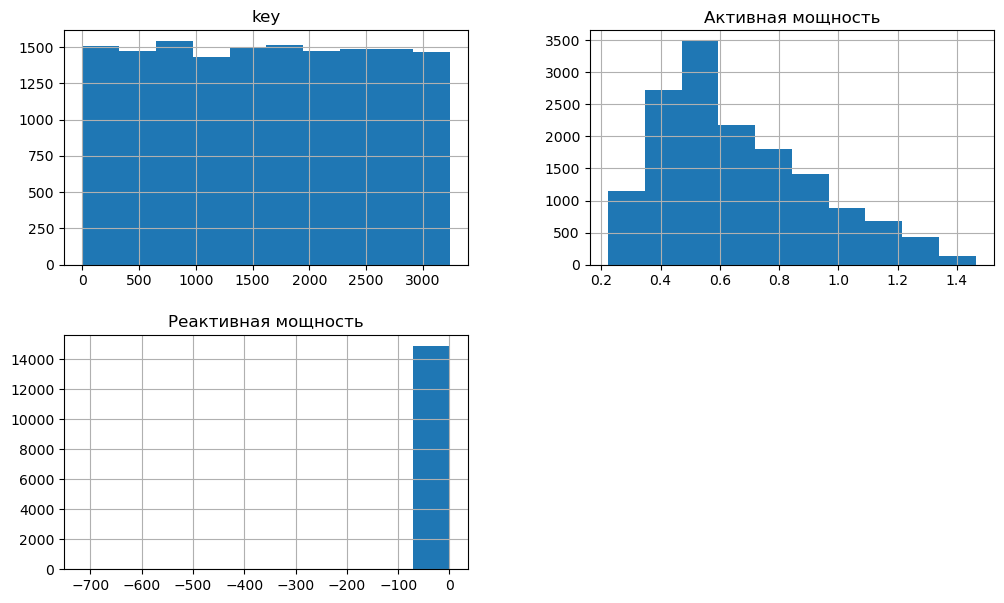

In [4]:
#Выведем базовую информацию о данных
data_arc.info()
print('-'*50)
print(data_arc.describe().transpose().round(3))
print('-'*50)
data_arc.hist(figsize=(12,7));
data_arc.head(5)

**Выводы по данным об электродах:**
1. В файле отображены данные о времени работы электродов, а также об их потребляемой мощности в процессе изготовления каждой партии;  
2. Названия столбцов не сответствуют правилам (есть заглавные буквы и пропуски);
3. Отсутствуют пропущенные значения;
4. У реактивной мощности есть аномальные значения;
5. Необходимо поменять формат для дат. Потом из него можно сделать признак "Время работы электродов".

In [5]:
#Переименуем названия столбцов
data_arc.columns = ['key', 'beginning_heating', 'finish_heating', 'active_power', 'reactive_power']
data_arc.columns

Index(['key', 'beginning_heating', 'finish_heating', 'active_power',
       'reactive_power'],
      dtype='object')

In [6]:
#Поменяем формат дат
for i in ['beginning_heating', 'finish_heating']:
    data_arc[i] = pd.to_datetime(data_arc[i], format='%Y-%m-%d %H:%M:%S')

In [7]:
#Сделаем еще один признак с продолжительность работы электродов
data_arc['work_time'] = data_arc['finish_heating'] - data_arc['beginning_heating']
data_arc['work_time'] = data_arc['work_time'].dt.total_seconds()
data_arc.head(5)

,key,beginning_heating,finish_heating,active_power,reactive_power,work_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0


In [8]:
#Проверим количество аномальных значений в реактивной мощности
data_arc['reactive_power'].loc[data_arc['reactive_power'] <= 0].count()

1

In [9]:
#Смело удаляем это значение
data_arc = data_arc.loc[data_arc['reactive_power'] > 0]

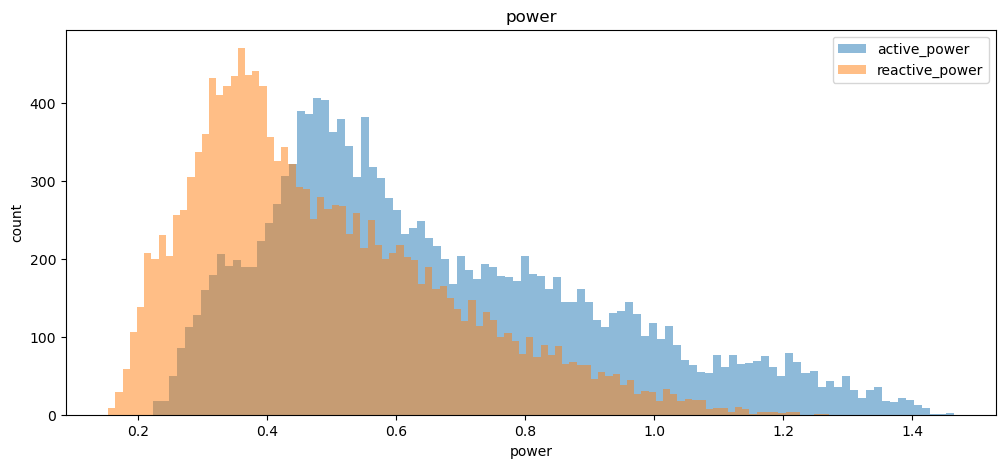

In [10]:
#Построим заново гистограммы распределения, проверим адекватность значений
plt.figure(figsize=(12,5))
for i in ['active_power', 'reactive_power']:
    plt.hist(data=data_arc, x=i, alpha=0.5, bins=100, label=i);
plt.title('power');
plt.xlabel('power');
plt.ylabel('count');
plt.legend();

In [11]:
#Удалим даты, сгруппируем таблицу по партиям, просуммировав и осреднив значения значения
data_arc_sum = data_arc.copy()
data_arc_sum = data_arc_sum.drop(['beginning_heating', 'finish_heating'], axis=1)
data_arc_sum = data_arc_sum.groupby('key').sum()
data_arc_sum.columns = ['active_power_sum', 'reactive_power_sum', 'work_time_sum']
data_arc_mean = data_arc.copy()
data_arc_mean = data_arc_mean.drop(['beginning_heating', 'finish_heating'], axis=1)
data_arc_mean = data_arc_mean.groupby('key').mean()
data_arc_mean.columns = ['active_power_mean', 'reactive_power_mean', 'work_time_mean']
data_arc_fin = pd.merge(data_arc_sum, data_arc_mean, on='key', how='inner')
data_arc_fin.head(5)

,active_power_sum,reactive_power_sum,work_time_sum,active_power_mean,reactive_power_mean,work_time_mean
key,,,,,,
1,3.036730,2.142821,1098.0,0.607346,0.428564,219.60
2,2.139408,1.453357,811.0,0.534852,0.363339,202.75
3,4.063641,2.937457,655.0,0.812728,0.587491,131.00
4,2.706489,2.056992,741.0,0.676622,0.514248,185.25
5,2.252950,1.687991,869.0,0.563238,0.421998,217.25


**Результаты:**
1. Переименованы столбцы;
2. Удалено 1 аномальное значение;
3. Сделана итоговая таблица для последующего объединения.

### Данные о подаче сыпучих материалов (объем)

In [12]:
#Подгружаем данные
try:
    data_bulk = pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Ля финаль/data_bulk_new.csv')
except:
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
--------------------------------------------------
          count      mean      std    min     25%     50%      75%     max
key      3129.0  1624.384  933

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


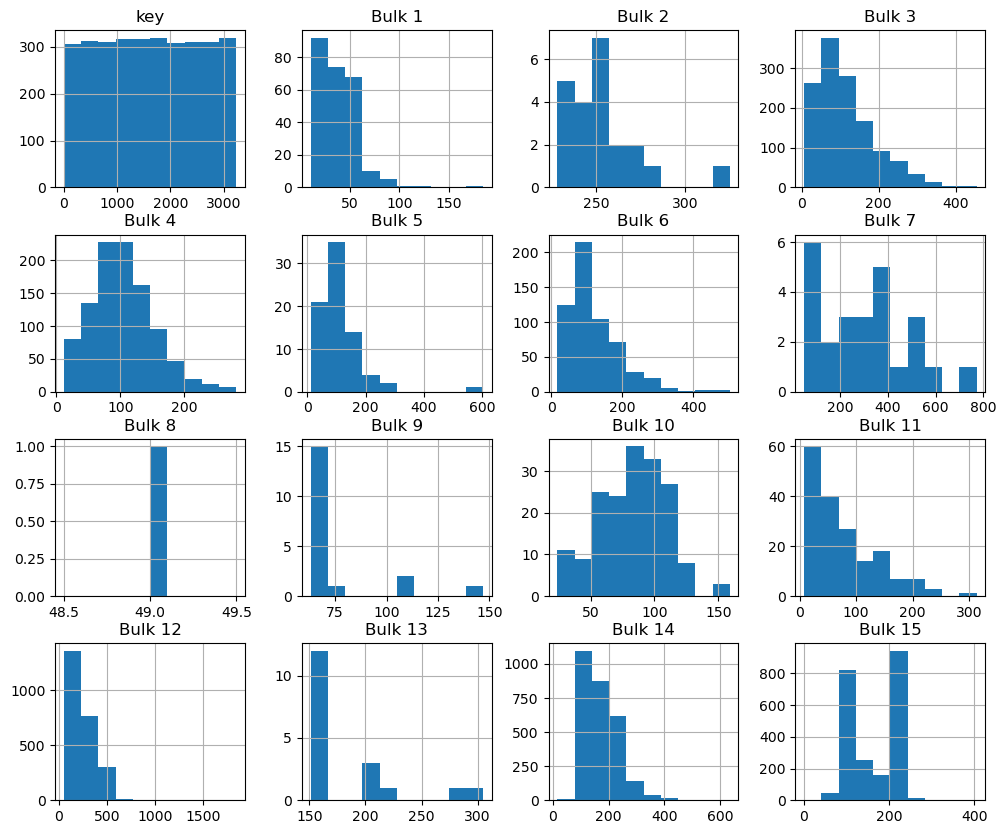

In [13]:
#Выведем базовую информацию о данных
data_bulk.info()
print('-'*50)
print(data_bulk.describe().transpose().round(3))
print('-'*50)
data_bulk.hist(figsize=(12,10));
data_bulk.head(5)

**Выводы по данным о сыпучих материалах (объем):**
1. В файле отображены данные о моменте времени подачи каждого из 15 сыпучих материалов для каждой партии отдельно;
2. Названия столбцов не сответствуют правилам (есть заглавные буквы и пропуски);
3. Много пропущенных значений, которые вероятно связаны с неиспользованием того или иного сыпучего материала в производстве для определенной партии;

In [14]:
#Поменяем названия столбцов
bulk_name = ['key']
for i in range(1,16):
    name = f'bulk_{i}'
    bulk_name.append(name)
data_bulk.columns = bulk_name
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

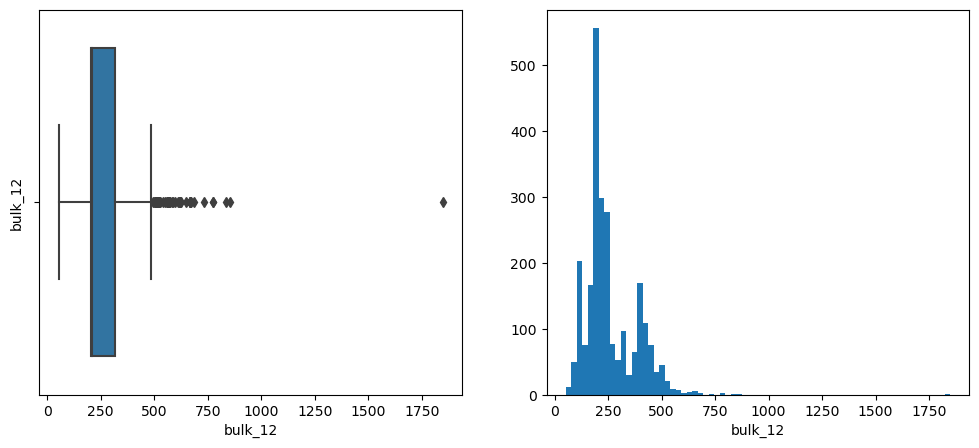

In [15]:
#Поcмотрим по-внимательнее на распределение значений для bulk_12
fig, axs = plt.subplots(nrows=1 , ncols=2, figsize=(12,5))

plt.subplot(121)
sns.boxplot(data_bulk['bulk_12']);
plt.ylabel('bulk_12');

plt.subplot(122)
plt.hist(data_bulk['bulk_12'], bins=70);
plt.xlabel('bulk_12');

Есть одно аномальное значение для bulc_12. Но оно не выглядит как какая-то ошибка в данных, возможно, нужно было действительно достаточно много данного сыпучего материала. Поэтому есть смысл его оставить.

In [16]:
#Заменим все NaN на ноль (материалы не использовались)
data_bulk_fin = data_bulk.copy()
data_bulk_fin = data_bulk_fin.fillna(0)
data_bulk_fin.head(5)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


**Результаты:**
1. Переименованы столбцы;
2. 1 аномальное значение в bulk_12 решено оставить;
3. Сделана итоговая таблица для последующего объединения.

### Данные о подаче сыпучих материалов (время)

In [17]:
#Подгружаем данные
try:
    data_bulk_time = pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Ля финаль/data_bulk_time_new.csv')
except:
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')

In [18]:
#Выведем базовую информацию о данных
data_bulk_time.info()
print('-'*50)
print(data_bulk_time.describe().transpose().round(3))
print('-'*50)
data_bulk_time.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
--------------------------------------------------
      count      mean      std  min    25%     50%     75%     max
key  3129.0  1624.384  933.338  1.0  816.0  1622.0  2431

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


**Выводы по данным о сыпучих материалах (время):**
1. В файле отображены данные об моменте времени подачи каждого из 15 сыпучих материалов для каждой партии отдельно;
2. Названия столбцов не сответствуют правилам (есть заглавные буквы и пропуски);
3. Много пропущенных значений, которые вероятно связаны с неиспользованием того или иного сыпучего материала в производстве для определенной партии;
4. Формат дат необходимо поменять.

**Результаты:**

Эти данные не пригодятся для создания модели, поэтмоу оставим их без предобработки, чтобы не тратить время.

### Данные о продувке сплава газом

In [19]:
#Подгружаем данные
try:
    data_gas = pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Ля финаль/data_gas_new.csv')
except:
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
--------------------------------------------------
        count      mean      std    min      25%       50%      75%       max
key    3239.0  1621.861  935.386  1.000  812.500  1622.000  2431.50  3241.000
Газ 1  3239.0    11.002    6.220  0.008    7.043     9.836    13.77    77.995
--------------------------------------------------


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


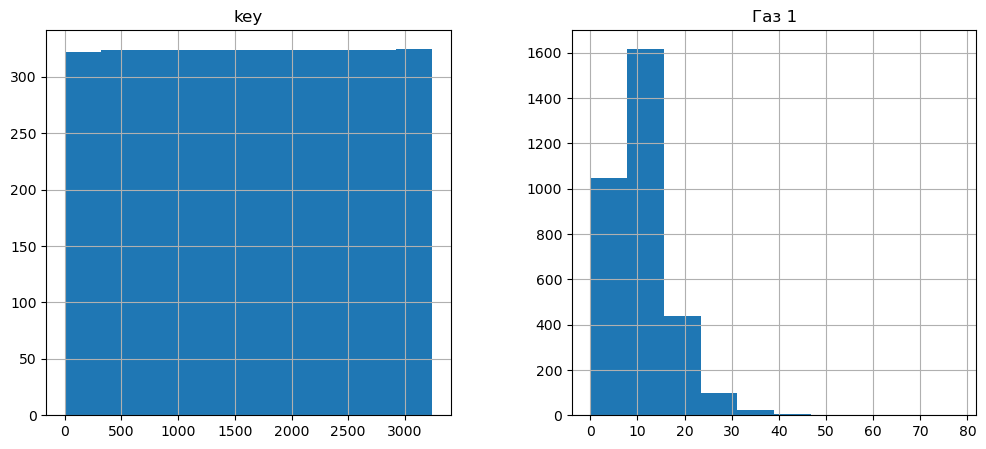

In [20]:
#Выведем базовую информацию о данных
data_gas.info()
print('-'*50)
print(data_gas.describe().transpose().round(3))
print('-'*50)
data_gas.hist(figsize=(12,5));
data_gas.head(5)

**Выводы по данным о продувке сплава газом:**
1. В файле отображены данные об объеме газа, использованного для продувки для каждой партии отдельно;
2. Нет пропущенных значений;
3. Названия столбцов не сответствуют правилам (есть заглавные буквы и пропуски).

In [21]:
#Переименуем названия столбцов
data_gas.columns = ['key', 'gas_1']
data_gas.columns

Index(['key', 'gas_1'], dtype='object')

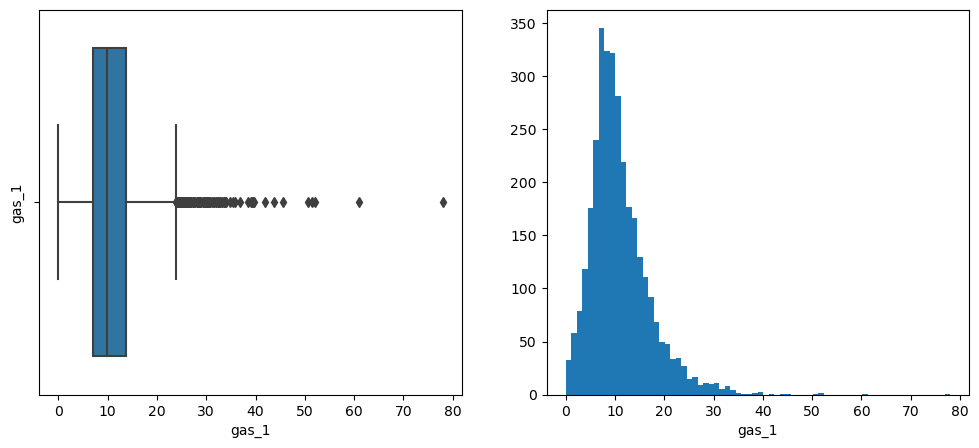

In [22]:
#Поcмотрим по-внимательнее на распределение значений для gas_1
fig, axs = plt.subplots(nrows=1 , ncols=2, figsize=(12,5))

plt.subplot(121)
sns.boxplot(data_gas['gas_1']);
plt.ylabel('gas_1');

plt.subplot(122)
plt.hist(data_gas['gas_1'], bins=70);
plt.xlabel('gas_1');

In [23]:
data_gas_fin = data_gas.copy()

Есть аномальные значения, но они не выглядят как какие-то ошибки в данных, возможно, нужно было действительно достаточно много объема газа для продувки. Поэтому есть смысл их оставить.

**Результаты:**

1. Переименованы столбцы;
2. Аномальные значения в gas_1 решено оставить;
3. Сделана итоговая таблица для последующего объединения.

### Данные о результатах измерения температуры

In [24]:
#Подгружаем данные
try:
    data_temp = pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Ля финаль/data_temp_new.csv')
except:
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
--------------------------------------------------
               count      mean      std     min      25%     50%     75%  \
key          18092.0  1616.461  934.641     1.0   807.75  1618.0  2429.0   
Температура  14665.0  1590.723   20.394  1191.0  1580.00  1590.0  1599.0   

                max  
key          3241.0  
Температура  1705.0  
--------------------------------------------------


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


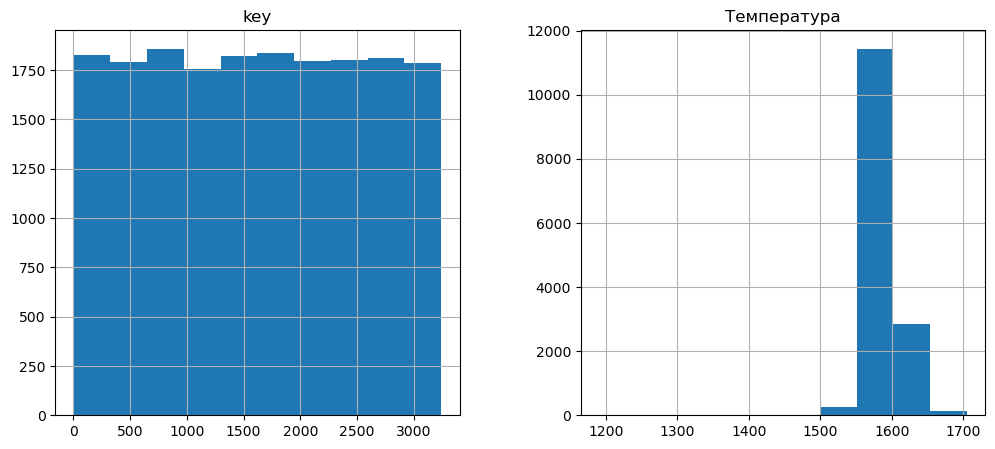

In [25]:
#Выведем базовую информацию о данных
data_temp.info()
print('-'*50)
print(data_temp.describe().transpose().round(3))
print('-'*50)
data_temp.hist(figsize=(12,5));
data_temp.head(5)

**Выводы по данным о результатах измерения температуры:**
1. В файле отображены данные о результатах замера температуры по времени в процессе изготовления каждой партии;
2. Есть пропущенные значения, вероятно, связанные с отсутствием замеров;
3. Есть аномально низкие значения (<1500 гр.);
4. Названия столбцов не сответствуют правилам (есть заглавные буквы);
5. Необходимо поменять формат дат.

In [26]:
#Переименуем названия столбцов
data_temp.columns = ['key', 'time_measure', 'temperature']
data_temp.columns

Index(['key', 'time_measure', 'temperature'], dtype='object')

In [27]:
#Поменяем формат дат
data_temp['time_measure'] = pd.to_datetime(data_temp['time_measure'], format='%Y-%m-%d %H:%M:%S')

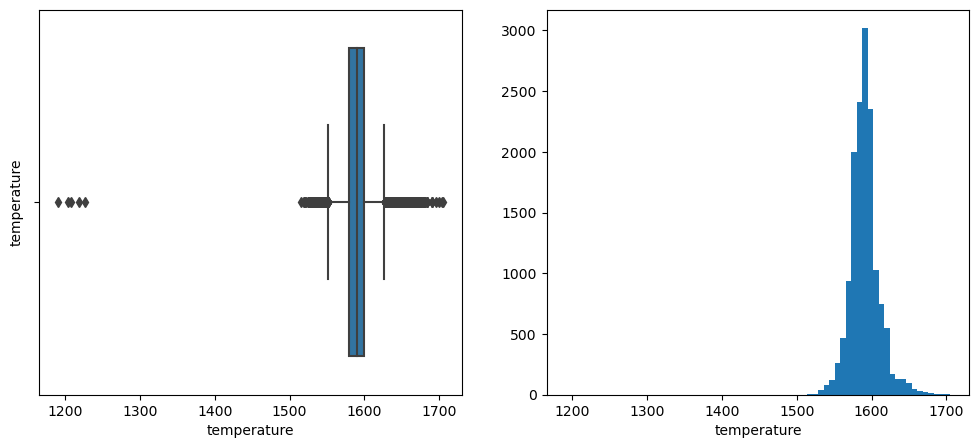

In [28]:
#Поcмотрим по-внимательнее на распределение значений для temperature
fig, axs = plt.subplots(nrows=1 , ncols=2, figsize=(12,5))

plt.subplot(121)
sns.boxplot(data_temp['temperature']);
plt.ylabel('temperature');

plt.subplot(122)
plt.hist(data_temp['temperature'], bins=70);
plt.xlabel('temperature');

Значений с температурой < 1500 гр. очень мало. \
Сначала проведем группировку, чтобы оставить только первую и последнюю температуру, а уже из группированной таблицы уберем вылетевшие (если они, конечно, останутся).
P.S. Гистограмма очень похожа на Бурдж Халифу)))

In [29]:
#Выберем последнюю температуру
data_temp_group = data_temp.copy()
data_temp_group = (data_temp_group
                   .sort_values(['key', 'time_measure'], ascending=True)
                   .groupby('key')
                   .max()
                   .drop('temperature', axis=1)
                  )
data_temp_last = pd.merge(data_temp_group, data_temp, on=['time_measure', 'key'], how='left')
data_temp_fin = data_temp_last.drop('time_measure', axis=1).rename(columns={'temperature':'last_temperature'})
data_temp_fin.head(10)

,key,last_temperature
0,1,1613.0
1,2,1602.0
2,3,1599.0
3,4,1625.0
4,5,1602.0
5,6,1596.0
6,7,1599.0
7,8,1598.0
8,9,1592.0
9,10,1593.0


In [30]:
#Выберем первую температуру
data_temp_group = data_temp.copy()
data_temp_group = (data_temp_group
                   .sort_values(['key', 'time_measure'], ascending=True)
                   .groupby('key')
                   .min()
                   .drop('temperature', axis=1)
                  )
data_temp_first = pd.merge(data_temp_group, data_temp, on=['time_measure', 'key'], how='left')
data_temp_fin['first_temperature'] = data_temp_first['temperature']
data_temp_fin.head(10)
data_temp_fin

,key,last_temperature,first_temperature
0,1,1613.0,1571.0
1,2,1602.0,1581.0
2,3,1599.0,1596.0
3,4,1625.0,1601.0
4,5,1602.0,1576.0
...,...,...,...
3211,3237,NaN,1569.0
3212,3238,NaN,1584.0
3213,3239,NaN,1598.0
3214,3240,NaN,1617.0


In [31]:
#Убираем партии, где была температура менее 1500 гр.
data_temp_fin = data_temp_fin.loc[(data_temp_fin['first_temperature'] >= 1500) 
                                  & (data_temp_fin['last_temperature'] >= 1500)]
data_temp_fin.info()
data_temp_fin.describe().transpose().round(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2473 non-null   int64  
 1   last_temperature   2473 non-null   float64
 2   first_temperature  2473 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.3 KB


,count,mean,std,min,25%,50%,75%,max
key,2473.0,1249.664,720.396,1.0,627.0,1251.0,1872.0,2499.0
last_temperature,2473.0,1595.338,16.031,1541.0,1587.0,1593.0,1599.0,1700.0
first_temperature,2473.0,1589.016,24.996,1519.0,1572.0,1588.0,1605.0,1679.0


**Результаты:**

1. Переименованы столбцы;
2. Сделана итоговая таблица для последующего объединения;
3. Осталось всего 2473 партии, где в целом есть последняя температура, которая выше 1500 гр. 

### Данные о проволочных материалах (объем)

In [32]:
#Подгружаем данные
try:
    data_wire = pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Ля финаль/data_wire_new.csv')
except:
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
--------------------------------------------------
         count     mean     std    min     25%      50%      75%      max
key     3081.0  1623.43  933.00   1.00  823.00  1619.00  2434.00  3241.00
Wire 1  3055.0   100.90   42.01   1.92   72.12   100.16   126.06   330.31
Wire 2  1079.0    50.58   39.32   0.03   20.19    40.14    70.23   282.78
Wire 3    63.0   189.48   99.51   0.14   95.14   2

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


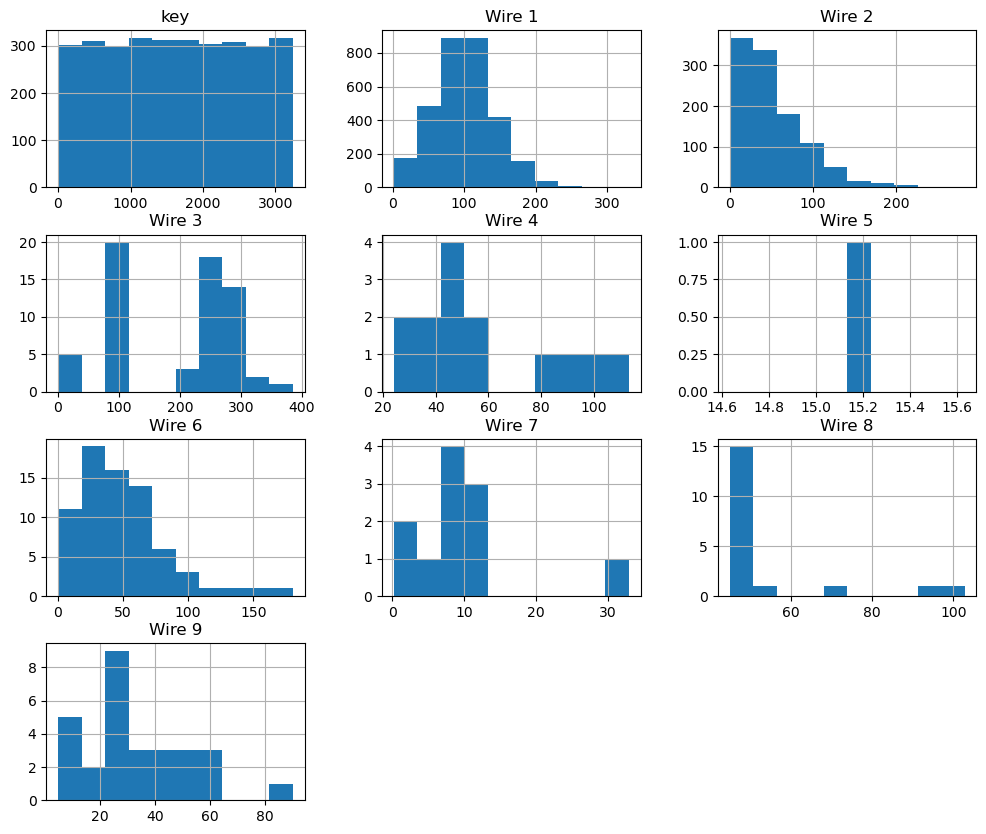

In [33]:
#Выведем базовую информацию о данных
data_wire.info()
print('-'*50)
print(data_wire.describe().transpose().round(2))
print('-'*50)
data_wire.hist(figsize=(12,10));
data_wire.head(5)

**Выводы по данным о проволочных материалах (объем):**
1. В файле отображены данные об объеме использования каждого из 9 проволочных материалов;
2. Есть пропущенные значения, вероятно, связанные с неиспользованием того или иного проволочного материала;
3. Названия столбцов не сответствуют правилам (есть заглавные буквы);

In [34]:
#Поменяем названия столбцов
wire_name = ['key']
for i in range(1,10):
    name = f'wire_{i}'
    wire_name.append(name)
data_wire.columns = wire_name
data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [35]:
#Заменим все NaN на ноль (материалы не использовались)
data_wire_fin = data_wire.copy()
data_wire_fin = data_wire.fillna(0)
data_wire_fin.head(5)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Результаты:**
1. Переименованы столбцы;
3. Сделана итоговая таблица для последующего объединения.

### Данные о проволочных материалах (время)

In [36]:
#Подгружаем данные
try:
    data_wire_time = pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Ля финаль/data_wire_time_new.csv')
except:
    data_wire_time = pd.read_csv('/datasets/data_bulc.csv')

In [37]:
#Выведем базовую информацию о данных
data_wire_time.info()
print('-'*50)
print(data_wire_time.describe().transpose().round(3))
print('-'*50)
data_wire_time.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
--------------------------------------------------
      count      mean      std  min    25%     50%     75%     max
key  3081.0  1623.426  932.997  1.0  823.0  1619.0  2434.0  3241.0
--------------------------------------------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Выводы по данным о проволочных материалах (время):**
1. В файле отображены данные о моменте времени использования каждого из 9 проволочных материалов;
2. Есть пропущенные значения, вероятно, связанные с неиспользованием того или иного проволочного материала;
3. Названия столбцов не сответствуют правилам (есть заглавные буквы);
4. Необходимо поменять формат дат.

**Результаты:**

Эти данные не пригодятся для создания модели, поэтому оставим их без предобработки, чтобы не тратить время.

### Объединение таблиц

Теперь необходимо объединить все финальные таблицы.

In [38]:
#Объединяем таблицы
data_1 = pd.merge(data_temp_fin, data_bulk_fin, on=['key'], how='inner')
data_2 = pd.merge(data_1, data_gas_fin, on=['key'], how='inner')
data_3 = pd.merge(data_2, data_arc_fin, on=['key'], how='inner')
data_fin = pd.merge(data_3, data_wire_fin, on=['key'], how='inner')

In [39]:
#Выведем базовую информацию о финальных данных
data_fin.info()
print('-'*50)
print(data_fin.describe().transpose().round(3))
print('-'*50)
data_fin.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2325 non-null   int64  
 1   last_temperature     2325 non-null   float64
 2   first_temperature    2325 non-null   float64
 3   bulk_1               2325 non-null   float64
 4   bulk_2               2325 non-null   float64
 5   bulk_3               2325 non-null   float64
 6   bulk_4               2325 non-null   float64
 7   bulk_5               2325 non-null   float64
 8   bulk_6               2325 non-null   float64
 9   bulk_7               2325 non-null   float64
 10  bulk_8               2325 non-null   float64
 11  bulk_9               2325 non-null   float64
 12  bulk_10              2325 non-null   float64
 13  bulk_11              2325 non-null   float64
 14  bulk_12              2325 non-null   float64
 15  bulk_13              2325 non-null   f

,key,last_temperature,first_temperature,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,work_time_mean,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1613.0,1571.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,219.60,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1602.0,1581.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,202.75,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1599.0,1596.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,131.00,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1625.0,1601.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,185.25,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1602.0,1576.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,217.25,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Как видно, пятый проволочный материал совсем не используется после объединения таблиц. Удалим этот признак, а также key 

In [40]:
#Удаляем wire_5 и key
data_fin = data_fin.drop(['wire_5', 'key'], axis=1)

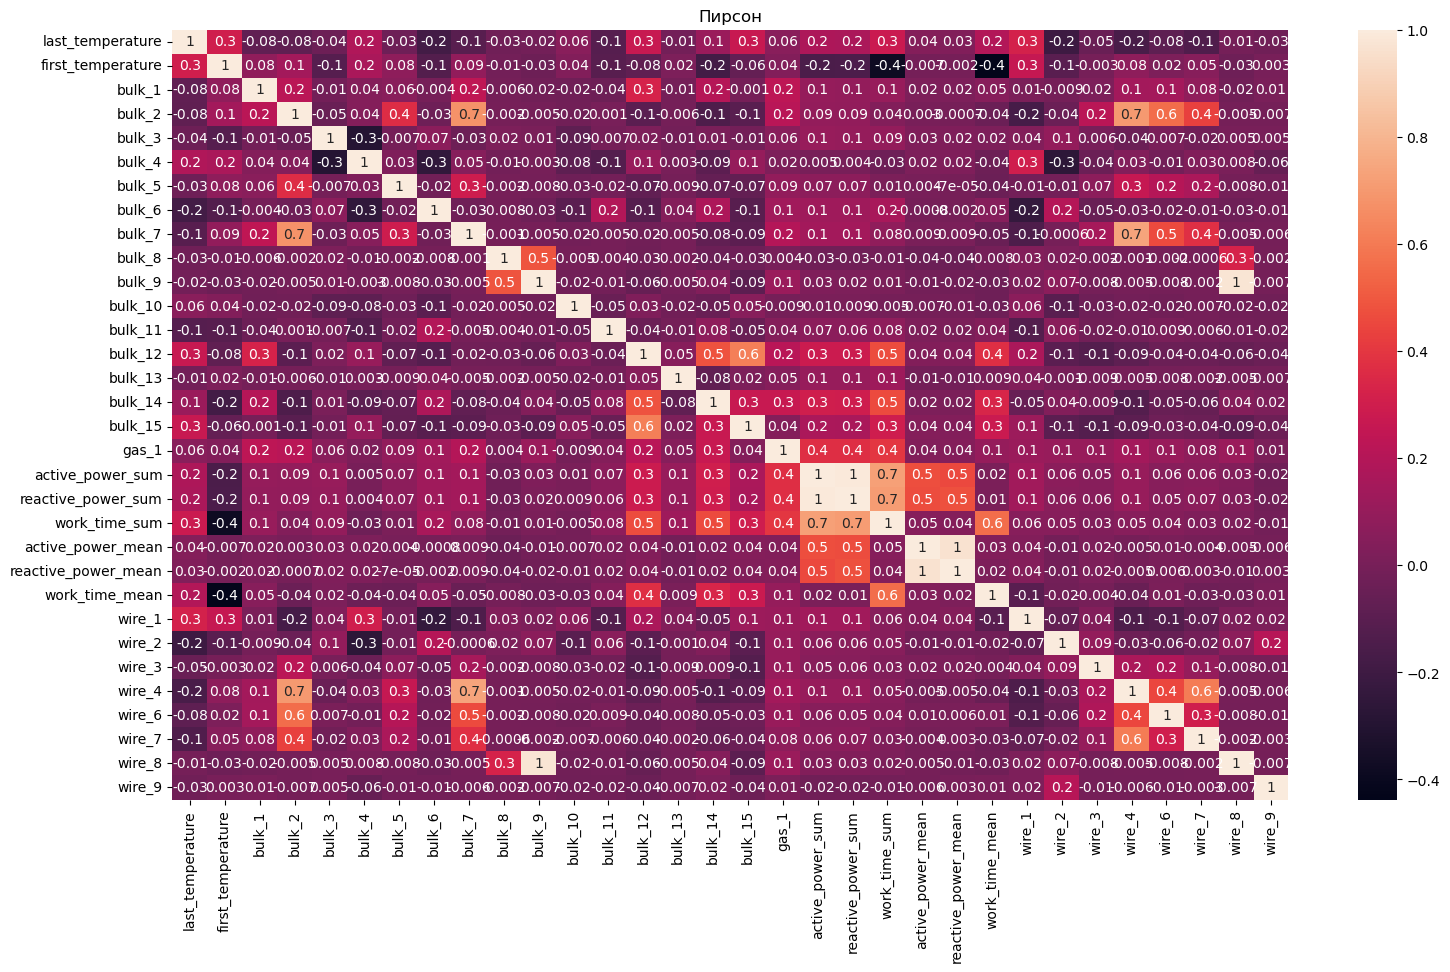

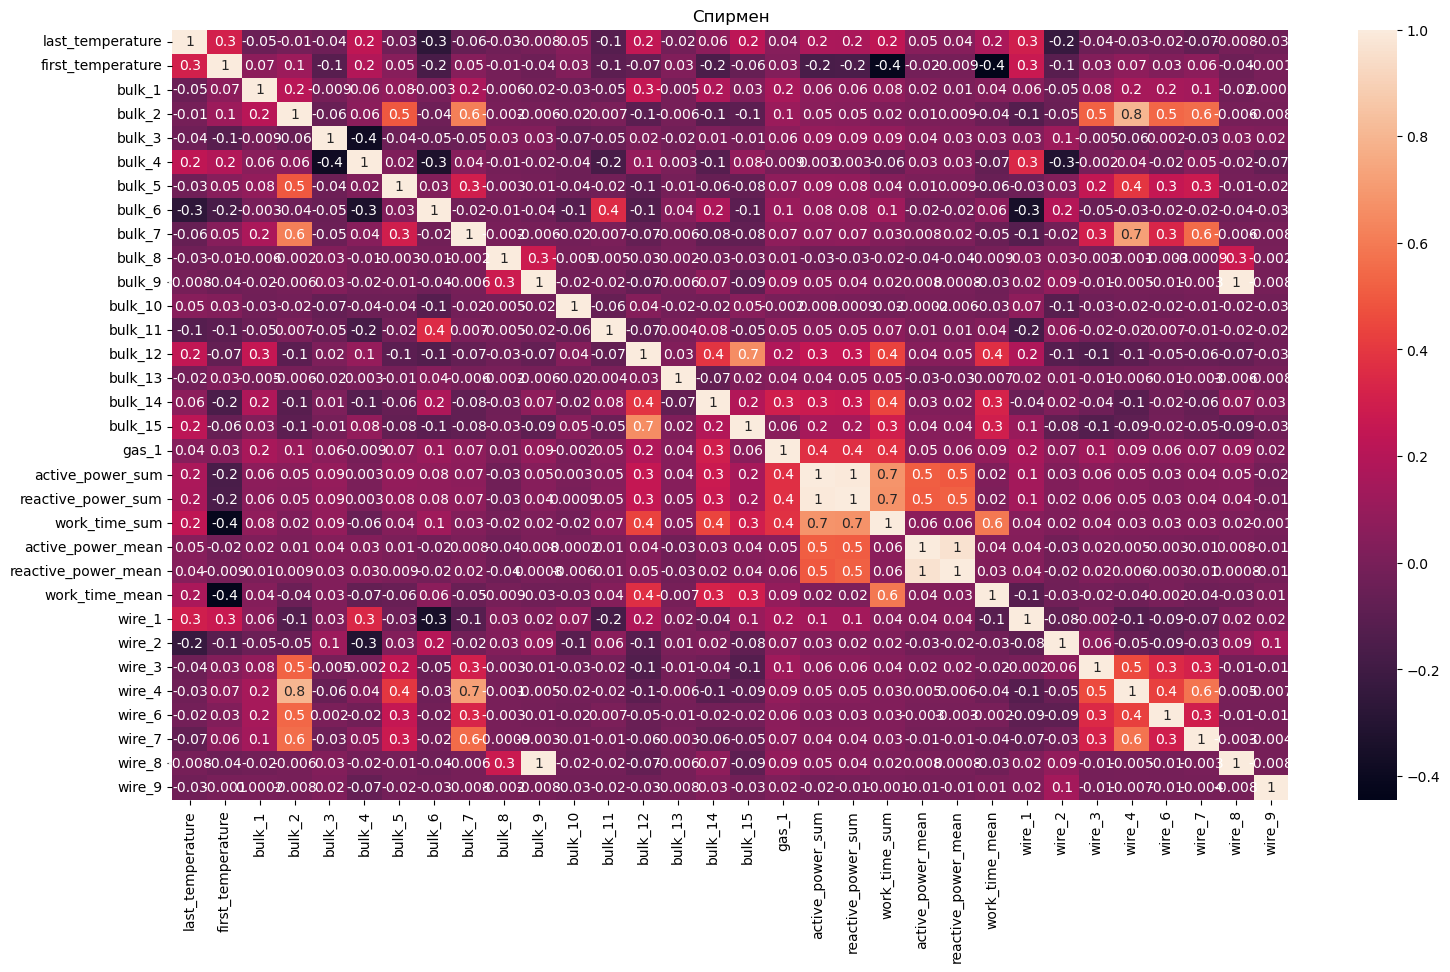

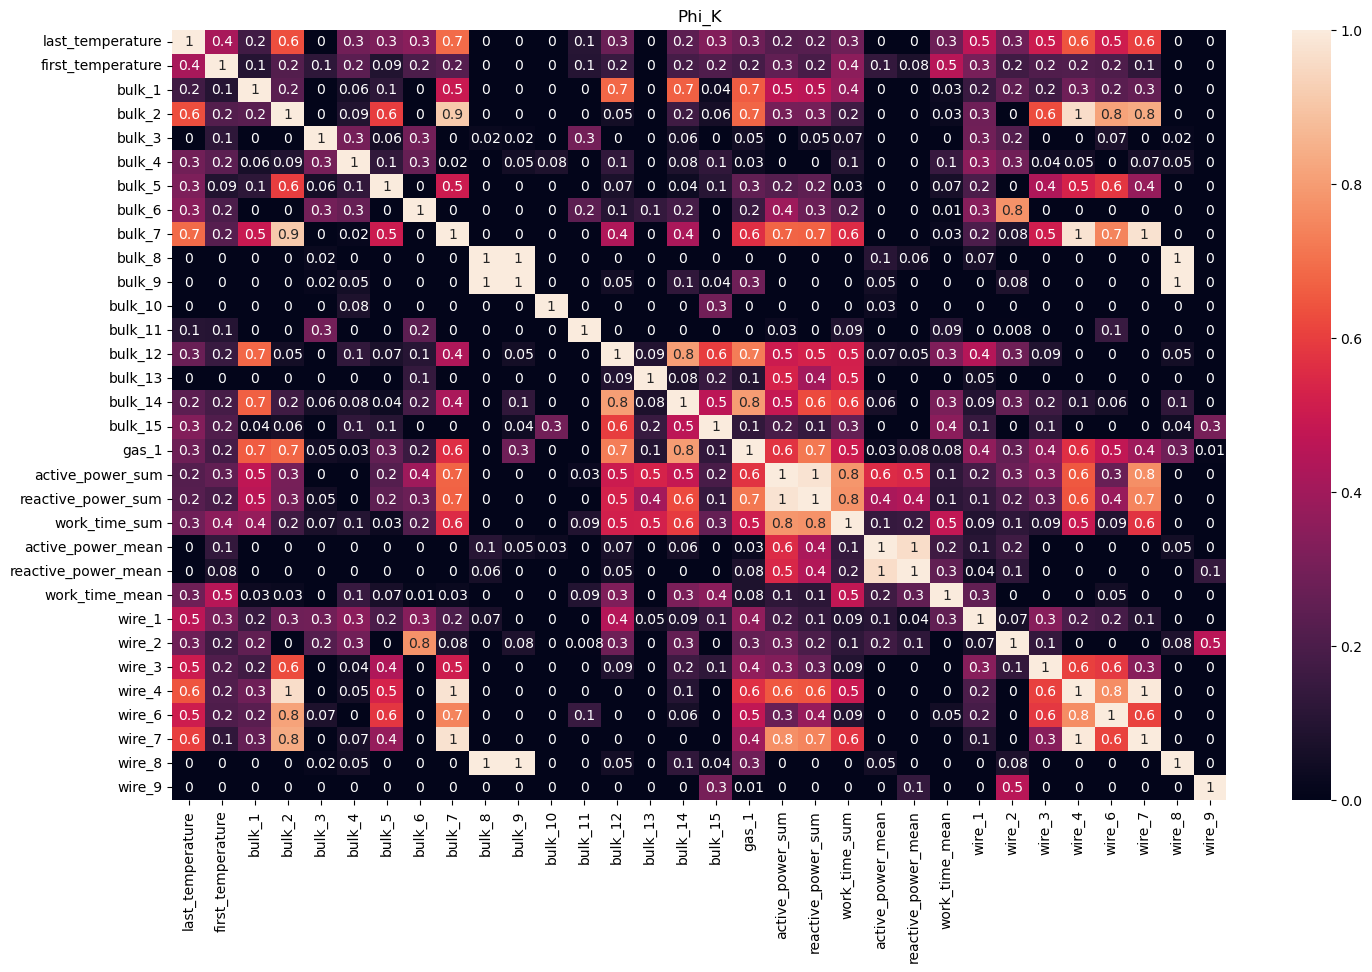

In [41]:
#Выведем тепловую карту, чтобы понять, какие параметры наибольшим образом коррелируют между собой
plt.figure(figsize=(18,10))
plt.title('Пирсон')
sns.heatmap(data_fin.corr(method='pearson'), annot=True, fmt='.1g');
plt.figure(figsize=(18,10))
plt.title('Спирмен')
sns.heatmap(data_fin.corr(method='spearman'), annot=True, fmt='.1g');

#Выделим некатегориальные признаки в отдельный список
int_list = list(data_fin.columns)

#Используем phik
plt.figure(figsize=(17,10))
plt.title('Phi_K')
sns.heatmap(data_fin.phik_matrix(int_list), annot=True, fmt='.1g');

Как мы видим из тепловых карт, у нас достаточно много параметров, сильно связанных между собой. Например, хорошо связаны между собой: 
* Данные о работе электродов; 
* Проволочные материалы с wire_3 по wire_7;
* Сыпучий материал bulk_2 и bulk_7 с проволочными материалами wire_3 по wire_7;
* bulk_9 с wire_8 имеют везде коэффициент корреляции 1 и т.д. 

In [42]:
#Выведем теперь параметр VIF для поиска коллинеарных признаков 
vif_data = pd.DataFrame()
vif_data['feature'] = data_fin[int_list].columns
vif_data['VIF'] = [variance_inflation_factor(data_fin[int_list].values, i) for i in range(len(data_fin[int_list].columns))]
vif_data.round(3)

,feature,VIF
0,last_temperature,9829.627
1,first_temperature,9331.559
2,bulk_1,1.495
3,bulk_2,2.909
4,bulk_3,1.631
5,bulk_4,2.001
6,bulk_5,1.195
7,bulk_6,1.530
8,bulk_7,2.734
9,bulk_8,3.737


Как мы видим особо колиинеарными параметрами являются последняя и начальная температуры, bulk_9, активная и реактивная мощности электродов, время работы электродов и wire_8

### Общие выводы по предобработке данных

1. Выделены и удалены аномальные значения, а также заполнены пропущенные занчения;
2. Выделены отдельно конечная (целевой признак) и начальная температура;
3. Все данные объединены в одну общую таблицу только для тех партий, где есть везде признаки (отсутствуют пропущенные значения);
4. Выделены некоторые связанные между собой признаки.

## Обучение и анализ моделей

In [43]:
#Разделим данные на выборки 75:25
features = data_fin.drop('last_temperature', axis=1)
target = data_fin['last_temperature']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=15823)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(1743, 31)
(1743,)
(582, 31)
(582,)


Используем 5 моделей: Дерево решений, Случайный лес, Линейная регрессия, LGBM и catboost

In [44]:
best_score_set = []

In [45]:
#Используем DecisionTreeRegressor вместе с RandomizedSearchCV
DT = DecisionTreeRegressor(random_state=15823)

rs_space={'max_depth':[None] + [i for i in range(2, 7)]}

DT_random = RandomizedSearchCV(DT, rs_space, n_iter=100, scoring='neg_mean_absolute_error', cv=5)
model_random = DT_random.fit(features_train, target_train)

best_model_DT = model_random.best_estimator_

best_score_set.append((-1) * round(model_random.best_score_, 3))

print(20 * '-')
print('Для DT:')
print('Лучшая модель:', best_model_DT)
print('Лучшие гиперпараметры:', model_random.best_params_)
print('Лучший MAE:', (-1) * round(model_random.best_score_, 3))

--------------------
Для DT:
Лучшая модель: DecisionTreeRegressor(max_depth=6, random_state=15823)
Лучшие гиперпараметры: {'max_depth': 6}
Лучший MAE: 7.04


In [46]:
#Используем RandomForestRegressor вместе с RandomizedSearchCV
RF = RandomForestRegressor(verbose=0, n_jobs=-1, random_state=15823)

rs_space={'max_depth':[None] + [i for i in range(2, 7)],
          'n_estimators':np.arange(1, 100, 2),
         }

RF_random = RandomizedSearchCV(RF, rs_space, n_iter=100, scoring='neg_mean_absolute_error', cv=5)
model_random = RF_random.fit(features_train, target_train)

best_model_RF = model_random.best_estimator_

best_score_set.append((-1) * round(model_random.best_score_, 3))

print(20 * '-')
print('Для RF:')
print('Лучшая модель:', best_model_RF)
print('Лучшие гиперпараметры:', model_random.best_params_)
print('Лучший MAE:', (-1) * round(model_random.best_score_, 3))

--------------------
Для RF:
Лучшая модель: RandomForestRegressor(n_estimators=87, n_jobs=-1, random_state=15823)
Лучшие гиперпараметры: {'n_estimators': 87, 'max_depth': None}
Лучший MAE: 6.329


In [47]:
#Используем LinearRegression вместе с RandomizedSearchCV
LR = LinearRegression()

rs_space={}

LR_random = RandomizedSearchCV(LR, rs_space, n_iter=1, scoring='neg_mean_absolute_error', cv=5)
model_random = LR_random.fit(features_train, target_train)

best_model_LR = LinearRegression()

best_score_set.append((-1) * round(model_random.best_score_, 3))

print('Лучший MAE:', (-1) * round(model_random.best_score_, 3))

Лучший MAE: 6.362


In [48]:
#Используем LightGBM вместе с RandomizedSearchCV
LGBM = lgb.LGBMRegressor(verbose=-1, n_jobs=-1, random_state=15823)

rs_space={'max_depth':([None] + [i for i in range(2, 7)]),
          'n_estimators':np.arange(10, 500, 50),
         }

LGBM_random = RandomizedSearchCV(LGBM, rs_space, n_iter=100, scoring='neg_mean_absolute_error', cv=5)
model_random = LGBM_random.fit(features_train, target_train)

best_model_LightGBM = model_random.best_estimator_

best_score_set.append((-1) * round(model_random.best_score_, 3))

print(20 * '-')
print('Для LGBM:')
print('Лучшая модель:', best_model_LightGBM)
print('Лучшие гиперпараметры:', model_random.best_params_)
print('Лучший MAE:', (-1) * round(model_random.best_score_, 3))

--------------------
Для LGBM:
Лучшая модель: LGBMRegressor(max_depth=5, n_estimators=60, random_state=15823, verbose=-1)
Лучшие гиперпараметры: {'n_estimators': 60, 'max_depth': 5}
Лучший MAE: 6.209


In [49]:
#Используем Catboost вместе с RandomizedSearchCV
catboost = CatBoostRegressor(verbose=0, random_state=15823)

rs_space={'max_depth':[None] + [i for i in range(2, 7)],
          'iterations':np.arange(10, 500, 50),
         }

catboost_random = RandomizedSearchCV(catboost, rs_space, n_iter=100, scoring='neg_mean_absolute_error', cv=5)
model_random = catboost_random.fit(features_train, target_train)

best_model_catboost = model_random.best_estimator_

best_score_set.append((-1) * round(model_random.best_score_, 3))

print(20 * '-')
print('Для catboost:')
print('Лучшая модель:', best_model_catboost)
print('Лучшие гиперпараметры:', model_random.best_params_)
print('Лучший MAE:', (-1) * round(model_random.best_score_, 3))

--------------------
Для catboost:
Лучшая модель: <catboost.core.CatBoostRegressor object at 0x000002AEDCFBF610>
Лучшие гиперпараметры: {'max_depth': 4, 'iterations': 460}
Лучший MAE: 6.131


In [50]:
#Найдем время обучения и предсказания без RandomizedSearchCV и кросс-валидации
#Также добавим МAE после кросс-валидации и RandomizedSearchCV
time_fit_set = []
time_pred_set = []

for i in [best_model_DT,
          best_model_RF,
          best_model_LR,
          best_model_LightGBM,
          best_model_catboost]:
    
    model = i
    
    #Обучаем и фиксируем время обучения
    start_time_fit = timeit.default_timer()
    model.fit(features_train, target_train)
    time_fit = timeit.default_timer() - start_time_fit
    
    #Делаем прогноз и фиксируем время прогноза
    start_time_pred = timeit.default_timer()
    model.predict(features_test)
    time_pred = timeit.default_timer() - start_time_pred
    
    time_fit_set.append(round(time_fit, 3))
    time_pred_set.append(round(time_pred, 3))
    
pivot_model = pd.DataFrame({'MAE' : best_score_set, 
                            'Время обучения' : time_fit_set, 
                            'Время прогноза' : time_pred_set,
                           }, 
                            index=['Дерево решений', 'Случайный лес', 'Линейная регрессия', 'LGBM', 'Catboost'])

pivot_model

,MAE,Время обучения,Время прогноза
Дерево решений,7.040,0.019,0.002
Случайный лес,6.329,0.354,0.020
Линейная регрессия,6.362,0.005,0.002
LGBM,6.209,0.061,0.002
Catboost,6.131,0.716,0.004


Лучшей моделью по MAE после кросс-валидации и подбора гиперпараметров является **Catboost c гиперпараметрами {'max_depth': 4, 'iterations': 460}**.

### Выводы по обучению и анализу моделей

1. Данные разделены на обучающую и тестовые выборки в соотношении 75:25;
2. 5 моделей обучены с разными гимерпараметрами с помощью RandomizedSearchCV и встроенной кросс-валидации (5 фолдов):
* LGBM 
* Catboost 
* Случайный лес 
* Дерево решений 
* Линейная регрессия
3. Лучшей моделью по MAE оказалась **Catboost c гиперпараметрами {'max_depth': 4, 'iterations': 460}**.

## Проверка модели

In [51]:
#Найдем MAE на тестовой выборке
model = best_model_catboost 
model.fit(features_train, target_train)
predictions = model.predict(features_test)
mae_test = mean_absolute_error(target_test, predictions)
print('-' * 20)
print('MAE тестовой выборки:', round(mae_test, 1))

--------------------
MAE тестовой выборки: 6.1


In [52]:
#Сравним результаты тестовой модели с константной
dummy_clf = DummyRegressor()
dummy_clf.fit(features_train, target_train)
predict_dummy = dummy_clf.predict(features_test)
mae_dummy = mean_squared_error(target_test, predict_dummy) ** 0.5
print('MAE константной модели составляет:', mae_dummy.round(1))

MAE константной модели составляет: 11.3


### Выводы по проверке модели

1. На тестовой выборке **MAE получился равным 6.1**;
2. На константной модели MAE получился равным 11.3, что **гораздо выше, чем MAE на тестовой выборке**

## Отчёт

### Использованный план действий

1. Исследвоательский анализ и предобработка данных каждого датафрейма. Необходимо убрать аномальные, заполнить/удалить/оставить пропущенные значения и возможно дубликаты;
2. Нас интересует каждая партия в отдельности, поэтому в каждом датафрейме, где это необходимо, проводим группировку по партии, используя функцию осредения и суммирования. Для температуры оставляем последнее значение для каждой партии, оно же итоговое. А также оставляем начальную температуру в качестве признака; 
3. Объединяем все таблицы, оставляя только партии, где нет пропущенных значений, а также не включая таблицы с временем задействования проволочных и сыпучих материалов. Из объединенной таблицы убираем все даты;
4. На основе итоговой таблицы выделяем целевой (температура) и обычные признаки, а также делим данные на обучающую и тестовую выборки в соотношении 75:25;
5. Используя перебор гиперпараметров с помощью RandomizedSearchCV, обучаем несколько видов моделей (дерево решений, случайный лес, линейная регрессия, LGBM и Catboost) и по лучшему значению метрики определяем лучшую модель;
6. Применяем лучшую модель на тестовой выборке и сравниваем результат с граничным значением метрики. А также на всякий случай сравниваем результат с baseline моделью DummyRegressor, чтобы в целом понять, настолько ли хорошо работает модель машинного обучения и нужна ли она была вообще.    

### Важность признаков 

Посмотрим гистограмму, которая покажет, какие признаки оказали наибольшее влияние на работу модели.

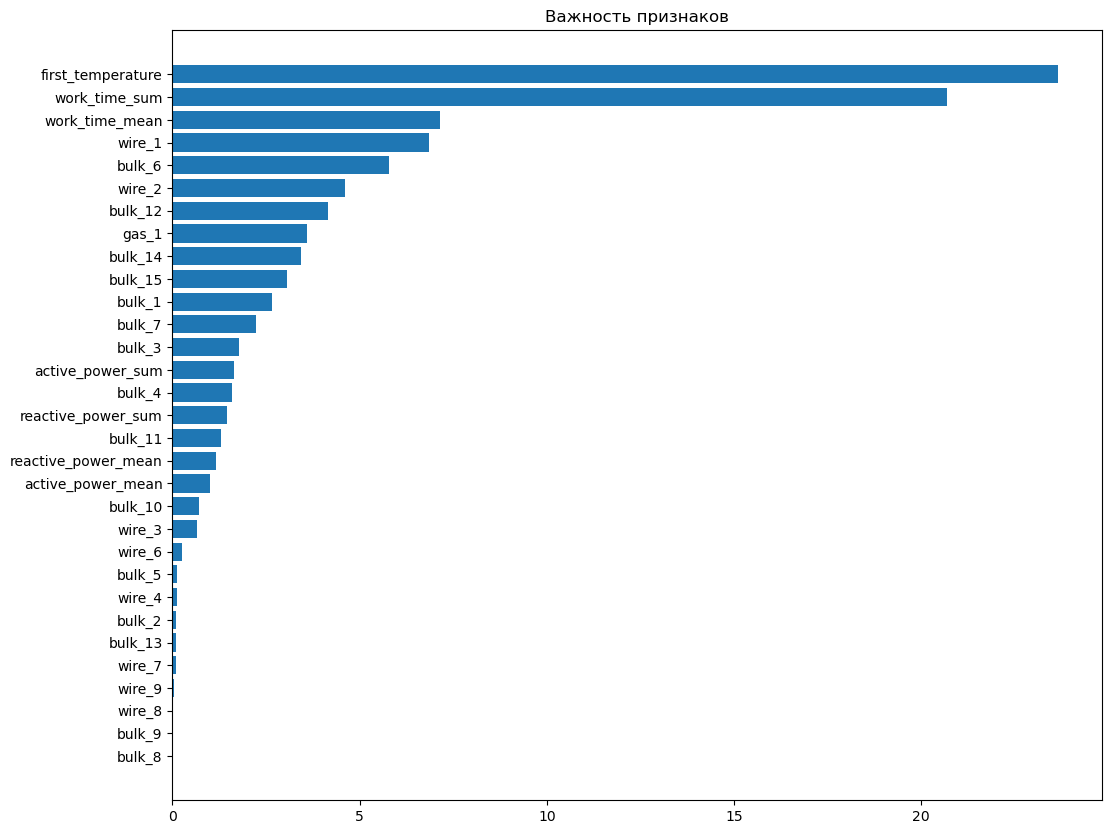

In [53]:
#Построим график важности признаков
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center');
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx]);
plt.title('Важность признаков');

**Некоторые выводы по гистограмме:**
1. Наибольшее влияние на конечный результат оказывает начальная температура, что логично, ведь конечная точка не могла бы быть получена без начальной;
2. Значительное влияние также оказало суммарное время работы электродов; 
3. Среди проволочных материалов особое влияние оказывают номера 1 и 2;
4. Среди сыпучих материалов особое влияние оказывают номера 6, 12, 14, 15, 1, 7, 3;
5. Активная и реактивные мощности не так сильно повлияли на результат.

### Общие выводы

Ниже приведены выводы по каждому основному этапу работы над проектом.

**1. Предобработка данных**:

1. Выделены и удалены аномальные значения (удалены строки с температурой <1500 гр. и 1 значение для реактивной мощности), а также заполнены пропущенные занчения (для сыпучих и проволочных материалов заменены на 0) или удалены;
2. Выделены отдельно конечная (целевой признак) и начальная температура;
3. Все данные объединены в одну общую таблицу только для тех партий, где есть везде признаки (отсутствуют пропущенные значения);
4. Выделены некоторые связанные между собой признаки.
------

**2. Обучение и анализ моделей**:

1. Данные разделены на обучающую и тестовые выборки в соотношении 75:25. Целевой признак - **конечная температура**. Признаки - все остальные параметры из общей таблицы, а именно:
* Средние и суммарные значения активной и реактивной мощностей, а также времени работы электродов;
* Объем использованного газа для продувки;
* Объемы использованных сыпучих и проволочных материалов (bulk и wire, соответственно);
* Начальная температура. 
2. 5 моделей обучены с разными гимерпараметрами с помощью RandomizedSearchCV и встроенной кросс-валидации (5 фолдов):
* LGBM 
* Catboost 
* Случайный лес 
* Дерево решений 
* Линейная регрессия
3. Лучшей моделью по MAE оказалась **Catboost c гиперпараметрами {'max_depth': 4, 'iterations': 460}**.

------

**3. Проверка модели**:

1. На тетсовой выборке **MAE получился равным 6.1**;
2. На константной модели MAE получился равным 11.3, что **гораздо выше, чем MAE на тестовой выборке**